A tutorial on logistic models (for predicting risk of software changes)
======
Full data is at:
  http://mockus.org/riskTut.zip and

* Version 3.2.1b
    * Except where otherwise noted, the content on this site is licensed under a Creative Commons Attribution 3.0 License.
 http://creativecommons.org/licenses/by/3.0/
 
* For a more in-depth coverage of data analysis approaches I highly recommend Advanced Data Analysis from an Elementary Point of View by Cosma Rohilla Shalizi. The complete pdf is at http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/

In [1]:
# For nicer printing
options(digits=2);

In [2]:
# Read in the data
risk <- read.table("risk1.paper",header=T);

#It typiaclly is a no-brainer for operational data: log-transform ALL the numeric variables
vars <- cbind (risk$isBad, log(risk$NS),log(risk$NM),log(risk$NF),log(risk$NLOGIN),
           log(risk$NMR),log(risk$ND),log(risk$LA+1),log(risk$LD+1),
           log(risk$LinesUnchanged+1),log(risk$to-risk$from+1),risk$logEXP,risk$logREXP,
           risk$logSEXP,risk$FIX);
dimnames(vars)[[2]] <- c("isBad","lNS", "lNM", "lNF", "lNLgn",  "lNMR", "lND",
                         "lLA", "lLD", "lLOC", "lINT", "lEXP", "lREXP", "lSEXP","FIX"); 

#R likes data.frame (as pythoin numpy): a matrix with (potentially) different types in each column
data <- data.frame(vars);

In [4]:
#now explore variables
summary(data);

     isBad           lNS            lNM           lNF          lNLgn    
 Min.   :0.00   Min.   :0.00   Min.   :0.0   Min.   :0.0   Min.   :0.0  
 1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.0   1st Qu.:0.0   1st Qu.:0.0  
 Median :0.00   Median :0.00   Median :0.0   Median :0.7   Median :0.0  
 Mean   :0.02   Mean   :0.29   Mean   :0.6   Mean   :1.0   Mean   :0.3  
 3rd Qu.:0.00   3rd Qu.:0.69   3rd Qu.:1.1   3rd Qu.:1.6   3rd Qu.:0.7  
 Max.   :1.00   Max.   :2.89   Max.   :6.5   Max.   :7.7   Max.   :3.6  
      lNMR          lND           lLA            lLD            lLOC     
 Min.   :0.0   Min.   :0.0   Min.   : 0.0   Min.   : 0.0   Min.   : 0.0  
 1st Qu.:0.0   1st Qu.:0.7   1st Qu.: 2.6   1st Qu.: 0.7   1st Qu.: 7.6  
 Median :0.7   Median :1.6   Median : 3.9   Median : 2.3   Median : 8.9  
 Mean   :0.9   Mean   :1.8   Mean   : 4.1   Mean   : 2.7   Mean   : 9.0  
 3rd Qu.:1.4   3rd Qu.:2.7   3rd Qu.: 5.4   3rd Qu.: 4.1   3rd Qu.:10.3  
 Max.   :5.7   Max.   :7.9   Max.   :14.4   M

### Interpret  basic summaries

In [5]:
cor(vars);# OK for normal distrubution
cor(vars,method="spearman"); #OK for any: uses ranks

,isBad,lNS,lNM,lNF,lNLgn,lNMR,lND,lLA,lLD,lLOC,lINT,lEXP,lREXP,lSEXP,FIX
isBad,1.0000,0.128,0.137,0.1308,0.124,0.142,0.136,0.1280,0.1211,0.118,0.099,-0.0333,-0.0318,-0.074,-0.0029
lNS,0.1283,1.000,0.824,0.7360,0.756,0.772,0.674,0.5836,0.5536,0.548,0.457,-0.0223,-0.0202,-0.616,-0.1794
lNM,0.1368,0.824,1.000,0.9027,0.757,0.827,0.817,0.7103,0.6630,0.649,0.533,0.0235,0.0335,-0.445,-0.2100
lNF,0.1308,0.736,0.903,1.0000,0.749,0.850,0.908,0.8024,0.7435,0.688,0.574,0.0046,0.0174,-0.392,-0.2463
lNLgn,0.1238,0.756,0.757,0.7491,1.000,0.808,0.733,0.6505,0.6338,0.601,0.592,-0.0796,-0.0824,-0.493,-0.2306
lNMR,0.1420,0.772,0.827,0.8504,0.808,1.000,0.877,0.7776,0.7506,0.720,0.644,-0.0526,-0.0496,-0.455,-0.2403
lND,0.1355,0.674,0.817,0.9078,0.733,0.877,1.000,0.8863,0.8557,0.792,0.635,-0.0309,-0.0144,-0.359,-0.2269
lLA,0.1280,0.584,0.710,0.8024,0.651,0.778,0.886,1.0000,0.8269,0.724,0.576,-0.0123,-0.0035,-0.310,-0.1999
lLD,0.1211,0.554,0.663,0.7435,0.634,0.751,0.856,0.8269,1.0000,0.698,0.562,-0.0200,-0.0027,-0.284,-0.2210
lLOC,0.1179,0.548,0.649,0.6882,0.601,0.720,0.792,0.7243,0.6976,1.000,0.517,-0.0434,-0.0351,-0.275,-0.1510


,isBad,lNS,lNM,lNF,lNLgn,lNMR,lND,lLA,lLD,lLOC,lINT,lEXP,lREXP,lSEXP,FIX
isBad,1.0000,0.100,0.1084,0.1097,0.100,0.113,0.113,0.115,0.105,0.106,0.10,-0.0374,-0.0336,-0.066,-0.0029
lNS,0.1004,1.000,0.7551,0.6501,0.644,0.652,0.577,0.512,0.477,0.489,0.44,-0.0272,-0.0191,-0.595,-0.1487
lNM,0.1084,0.755,1.0000,0.8561,0.646,0.743,0.744,0.653,0.591,0.605,0.51,-0.0092,0.0063,-0.388,-0.1735
lNF,0.1097,0.650,0.8561,1.0000,0.635,0.770,0.862,0.757,0.672,0.647,0.54,-0.0160,0.0031,-0.327,-0.2093
lNLgn,0.0999,0.644,0.6457,0.6352,1.000,0.696,0.638,0.577,0.558,0.551,0.62,-0.0968,-0.0909,-0.447,-0.2134
lNMR,0.1130,0.652,0.7432,0.7702,0.696,1.000,0.835,0.736,0.696,0.690,0.64,-0.0593,-0.0481,-0.382,-0.2024
lND,0.1128,0.577,0.7438,0.8615,0.638,0.835,1.000,0.868,0.819,0.772,0.61,-0.0536,-0.0311,-0.303,-0.1928
lLA,0.1146,0.512,0.6532,0.7571,0.577,0.736,0.868,1.000,0.776,0.707,0.56,-0.0314,-0.0182,-0.262,-0.1723
lLD,0.1052,0.477,0.5907,0.6716,0.558,0.696,0.819,0.776,1.000,0.664,0.54,-0.0447,-0.0188,-0.245,-0.1982
lLOC,0.1057,0.489,0.6050,0.6472,0.551,0.690,0.772,0.707,0.664,1.000,0.52,-0.0591,-0.0457,-0.258,-0.1443


Interpret correlations

Now, just show top correlations

In [6]:
# Define a function
hiCor <- function(x, level){
  res <- cor(x,method="spearman");
  res1 <- res; res1[res<0] <- -res[res < 0];
  for (i in 1:dim(x)[2]){
    res1[i,i] <- 0;
  }
  sel <- apply(res1,1,max) > level;
  res[sel,sel];
}
hiCor(data,.7)

,lNS,lNM,lNF,lNMR,lND,lLA,lLD,lLOC,lEXP,lREXP
lNS,1.000,0.7551,0.6501,0.652,0.577,0.512,0.477,0.489,-0.0272,-0.0191
lNM,0.755,1.0000,0.8561,0.743,0.744,0.653,0.591,0.605,-0.0092,0.0063
lNF,0.650,0.8561,1.0000,0.770,0.862,0.757,0.672,0.647,-0.0160,0.0031
lNMR,0.652,0.7432,0.7702,1.000,0.835,0.736,0.696,0.690,-0.0593,-0.0481
lND,0.577,0.7438,0.8615,0.835,1.000,0.868,0.819,0.772,-0.0536,-0.0311
lLA,0.512,0.6532,0.7571,0.736,0.868,1.000,0.776,0.707,-0.0314,-0.0182
lLD,0.477,0.5907,0.6716,0.696,0.819,0.776,1.000,0.664,-0.0447,-0.0188
lLOC,0.489,0.6050,0.6472,0.690,0.772,0.707,0.664,1.000,-0.0591,-0.0457
lEXP,-0.027,-0.0092,-0.0160,-0.059,-0.054,-0.031,-0.045,-0.059,1.0000,0.9595
lREXP,-0.019,0.0063,0.0031,-0.048,-0.031,-0.018,-0.019,-0.046,0.9595,1.0000


## So much correlation is typical in SE
* How to select an orthogonal subset of predictors?

Lets take a look at principal components

     lNM  lNF lNLgn lNMR  lND  lLA lLD
PC1 0.32 0.33  0.31 0.34 0.34 0.31 0.3
     lEXP lREXP lSEXP
PC2 -0.65 -0.66 -0.33
    isBad FIX
PC3  0.84 0.5
      lNS lSEXP
PC4 -0.46  0.54
    isBad   FIX
PC5   0.5 -0.84


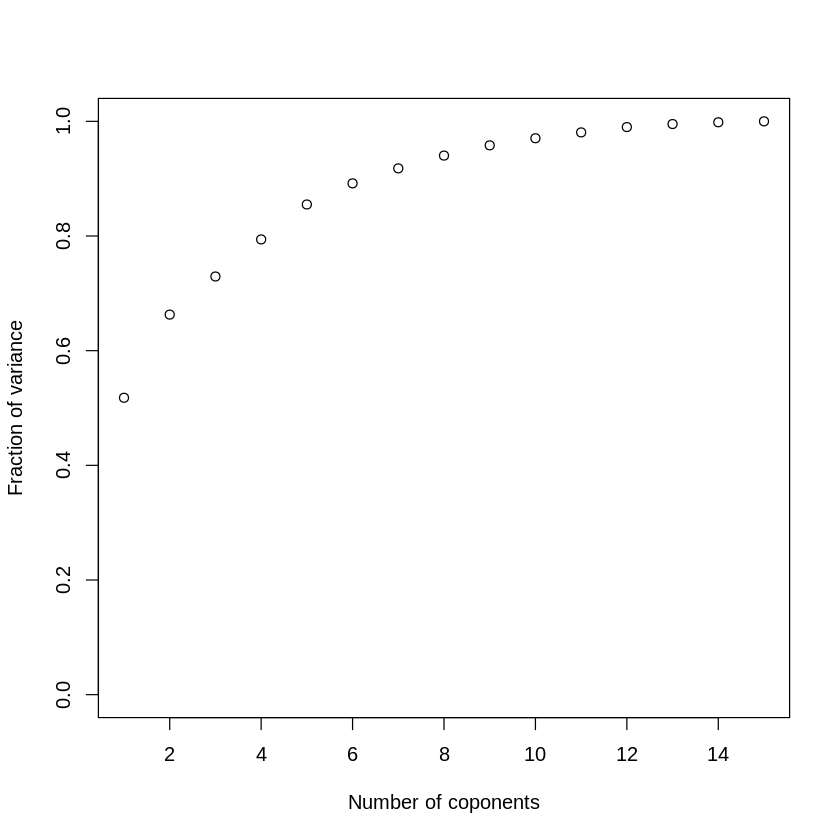

In [7]:
plot(1:15,cumsum(prcomp(vars, retx=F,scale=T)$sdev^2)/sum(prcomp(vars, retx=F,scale=T)$sdev^2),ylim=c(0,1),xlab="Number of coponents",ylab="Fraction of variance");
res<-prcomp(vars, retx=F,scale=T)$rotation[,1:5];
resAbs <- res;
resAbs[res<0] <- -res[res<0];
for (i in 1:5)
  print(t(res[resAbs[,i]>.3,i,drop=FALSE]));

* Regress each predictor on the remaining predictors
eliminate with the highest adjR^2

In [8]:
res <- c();
vnam <- names(data);
for (i in 2:dim(data)[2]){
  fmla <- as.formula(paste(vnam[i],paste(vnam[-c(1,i)],collapse="+"),sep="~"));
  res <- rbind(res,c(i,round(summary(lm(fmla,data=data))$r.squared,2)));
}
row.names(res) <- vnam[res[,1]];
res[order(-res[,2]),];

lEXP,12,0.95
lREXP,13,0.95
lND,7,0.94
lNF,4,0.91
lNM,3,0.87
lNMR,6,0.86
lLA,8,0.81
lNS,2,0.80
lLD,9,0.76
lNLgn,5,0.72
lLOC,10,0.65


### Finally select the model
  Note, that exploring only the predictor space is not leading to
     multiple comparisons issue!

  * replace lSEXP by lEXP: simpler 
  * why lLOC, lLA, lLD, lND, lNlgn: keep lND as most stable, keep lLOC?

In [9]:
fmla ~ isBad ~ lNS+lLA+FIX+lLOC+lINT+lEXP

fmla ~ isBad ~ lNS + lLA + FIX + lLOC + lINT + lEXP

* We'll need to do prediction, so drop last few years

In [10]:
data1 <- data;
data1$from <- risk$from/3600/24/365.25+1970;
dataFit <- data1[data1$from<=1997,]; #80%
dataTest <- data1[data1$from>1997,]; #20%

In [11]:
mod <- glm(isBad ~ lNS+lLA+FIX+lLOC+lINT+lEXP,family=binomial,data=dataFit);
summary(mod); 


Call:
glm(formula = isBad ~ lNS + lLA + FIX + lLOC + lINT + lEXP, family = binomial, 
    data = dataFit)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.842  -0.225  -0.169  -0.132   3.327  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.79427    0.45010  -12.87  < 2e-16 ***
lNS          0.35650    0.10268    3.47  0.00052 ***
lLA          0.17910    0.04751    3.77  0.00016 ***
FIX          0.53314    0.12943    4.12  3.8e-05 ***
lLOC         0.13590    0.04948    2.75  0.00603 ** 
lINT         0.01788    0.00925    1.93  0.05322 .  
lEXP        -0.10757    0.03829   -2.81  0.00497 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3011.5  on 13480  degrees of freedom
Residual deviance: 2739.0  on 13474  degrees of freedom
AIC: 2753

Number of Fisher Scoring iterations: 7


Note AIC: 2753

threfore lINT probably not important

### Good to order by variance explained (Anova Deviance/Df)

In [12]:
anova(mod, test="Chi");

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,13480,3012,NA
lNS,1,166.1,13479,2845,5.3e-38
lLA,1,65.1,13478,2780,7.0e-16
FIX,1,17.4,13477,2763,3.0e-05
lLOC,1,10.7,13476,2752,1.1e-03
lINT,1,5.5,13475,2747,1.9e-02
lEXP,1,7.7,13474,2739,5.4e-03


A similar picture, lINT does not explain as much as others

In [13]:
mod <- glm(isBad ~ lNS+lND+FIX+lEXP+lINT,family=binomial,data=dataFit);
summary(mod);


Call:
glm(formula = isBad ~ lNS + lND + FIX + lEXP + lINT, family = binomial, 
    data = dataFit)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-0.851  -0.223  -0.170  -0.135   3.235  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.48210    0.28367  -15.80  < 2e-16 ***
lNS          0.31994    0.11021    2.90   0.0037 ** 
lND          0.36503    0.05354    6.82  9.2e-12 ***
FIX          0.52993    0.12873    4.12  3.8e-05 ***
lEXP        -0.10508    0.03799   -2.77   0.0057 ** 
lINT         0.01847    0.00941    1.96   0.0496 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3011.5  on 13480  degrees of freedom
Residual deviance: 2750.4  on 13475  degrees of freedom
AIC: 2762

Number of Fisher Scoring iterations: 7


### Slightly higher AIC: 2762, but a simpler model
   * don't chase the best fit, as it leads to overfitting

In [14]:
anova(mod, test="Chi");#it is good to order predictors by deviance explained

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,13480,3012,NA
lNS,1,166.1,13479,2845,5.3e-38
lND,1,64.3,13478,2781,1.1e-15
FIX,1,17.7,13477,2763,2.6e-05
lEXP,1,9.3,13476,2754,2.4e-03
lINT,1,3.8,13475,2750,5.0e-02


* Note: use test="F" for linear models (lm)
* Note: R's anova order matters in variance explained, as
  each SS is based on the residuals from predictors going before it
* Alternative sum of squares for ANOVA are obtained via drop1
*  In this case it is based on the residuals of remaining predictors (not
  just of preceeding predictors

In [15]:
drop1(mod, test="Chi");

,Df,Deviance,AIC,LRT,Pr(>Chi)
<none>,NA,2750,2762,NA,NA
lNS,1,2759,2769,8.6,3.3e-03
lND,1,2795,2805,44.4,2.6e-11
FIX,1,2767,2777,16.8,4.1e-05
lEXP,1,2758,2768,7.5,6.1e-03
lINT,1,2754,2764,3.8,5.0e-02


### Variance inflation factor
 http://en.wikipedia.org/wiki/Variance_inflation_factor

In [16]:
library(car)
vif(mod);

lNS  lND  FIX lEXP lINT 
 2.3  3.1  1.2  1.0  1.9

￼
* Is less than 5 (max is 3.1 for lND), but lower would be better

### Exercise: other diagnostics
* is model stable if some data is dropped?
* what if we change data as in GDF?
* is there a time trend 
    isBad ~ lNS+lND+FIX+lEXP+lINT+from
* independece (residuals)

Now interpret the model
* What do estimated coefficients mean?
* Increase NS from 1 to 2, but other predictors matter
* threfore pick values that are reasonable or a median

In [17]:
try <- dataFit[1:2,];
for (i in dim(dataFit)[2])
  try[,i] <- median(dataFit[,i]);
try[1,"lNS"] <- 0;
try[2,"lNS"] <- log(2);
res <- 1/(1+exp(-predict(mod,try)));
res[2]*(1-res[1])/res[1]/(1-res[2]);

2 
1.9

### The answer is how much the risk increases if number of subsystems touched is increased from 1 to 2
  * First ratio of risk then 
  * ratio of odds

# Do prediction

In [21]:
predicted <- 1/(1+exp(-predict(mod,dataTest)));
print(tapply(predicted, dataTest$isBad, mean))

    0     1 
0.022 0.060 


## Good to know
* predicted probability is almost three times higher for the MRs that break patches

### Traditional performance:

In [22]:
for (cutof in c(.01, .015, .02, .03, .04, .045,.1)){
  res <- table(predicted>cutof, dataTest$isBad);
  type1 <- res[2,1]/(res[1,1]+res[2,1]);
  type2 <- res[1,2]/(res[1,2]+res[2,2]);
  recall <- 1 - type2;
  precision <- res[2,2]/(res[2,1]+res[2,2]);
  print (c(cutof,type1,type2,recall,precision));
}

[1] 0.010 0.661 0.120 0.880 0.017
[1] 0.015 0.435 0.260 0.740 0.021
[1] 0.020 0.307 0.420 0.580 0.024
[1] 0.030 0.177 0.440 0.560 0.039
[1] 0.040 0.126 0.520 0.480 0.046
[1] 0.045 0.109 0.540 0.460 0.051
[1] 0.100 0.026 0.740 0.260 0.114


### A single number such as ROC typically makes little sense:
* in this case the primary concern is decent recall

### Exercise:
* compare to a random predictor
* compare to a simple predictor, e.g, more than one subsystem

### Try other prediction methods

In [23]:
library(rpart);

fmla <- isBad ~ lNS+lND+FIX+lINT+lEXP+lLA;
er <- c();
for (w in c(20,40,60,80, 100, 110)){ 
  cart.fit <- rpart(fmla,data=dataFit,method="class",weights=as.numeric(dataFit$isBad)*w+1);
  cart.pred <- predict(cart.fit,newdata=dataTest,type="class");
  res <- table(cart.pred, dataTest$isBad);
  type1 <- res[2,1]/(res[1,1]+res[2,1]);
  type2 <- res[1,2]/(res[1,2]+res[2,2]);
  recall <- 1 - type2;
  precision <- res[2,2]/(res[2,1]+res[2,2]);
  er <- rbind (er, c(w,type1,type2,recall,precision));
}
er;

20,0.087,0.54,0.46,0.064
40,0.363,0.34,0.66,0.023
60,0.481,0.26,0.74,0.019
80,0.553,0.20,0.80,0.018
100,0.645,0.14,0.86,0.017
110,0.645,0.14,0.86,0.017


In [24]:
### Slightly worse than the regression model

In [25]:
cart.fit <- rpart(fmla,data=dataFit,method="class",weights=as.numeric(dataFit$isBad)*w+1);
cart.pred <- predict(cart.fit,newdata=dataTest,type="class");
cart.pred;

10900 11517 11760 12248 12257 12265 12281 12346 12369 12449 12695 12705 12727 
    1     1     0     1     0     1     1     1     1     1     1     1     1 
12759 12861 12881 12895 12927 12957 12979 13010 13013 13038 13039 13066 13067 
    1     0     1     1     1     1     1     1     1     1     0     1     1 
13069 13070 13081 13088 13110 13114 13116 13118 13119 13120 13121 13126 13132 
    1     1     0     1     0     1     0     1     1     1     1     1     1 
13133 13138 13141 13155 13164 13176 13181 13185 13186 13190 13192 13197 13198 
    0     0     1     1     1     1     0     1     1     1     1     1     1 
13199 13204 13205 13207 13219 13237 13238 13239 13240 13241 13249 13252 13253 
    0     1     0     1     1     1     1     0     1     0     0     0     0 
13254 13255 13256 13258 13262 13265 13270 13271 13273 13275 13276 13277 13279 
    1     0     1     1     1     1     1     0     1     1     0     1     0 
13280 13281 13282 13283 13284 13285 13287 13288 13289 13290 13291 13292 13293 
    0     0     1     0     1     1     1     1     1     0     0     0     0 
13294 13295 13296 13297 13298 13300 13301 13302 13303 13306 13307 13309 13310 
    1     0     0     1     1     0     1     0     0     1     0     0     0 
13311 13312 13313 13315 13317 13319 13320 13321 13322 13323 13324 13325 13326 
    0     1     1     1     0     0     0     0     1     1     0     0     1 
13327 13328 13329 13330 13331 13333 13334 13335 13337 13338 13340 13341 13344 
    1     0     1     0     0     1     0     1     1     1     1     0     1 
13345 13346 13347 13348 13350 13351 13352 13353 13354 13355 13358 13359 13360 
    1     1     0     0     1     0     1     1     0     0     1     1     1 
13361 13363 13364 13365 13368 13371 13372 13374 13375 13376 13377 13378 13379 
    1     0     1     1     1     1     1     0     0     1     1     0     1 
13380 13381 13382 13383 13384 13385 13386 13387 13389 13390 13391 13392 13393 
    0     0     1     1     1     1     0     0     1     0     0     1     1 
13394 13395 13396 13397 13398 13400 13401 13402 13403 13404 13405 13406 13407 
    1     0     0     1     0     1     1     1     0     1     1     1     0 
13408 13409 13410 13412 13413 13414 13415 13416 13420 13422 13423 13424 13426 
    1     1     1     0     1     1     1     0     0     1     1     1     1 
13427 13428 13429 13430 13431 13432 13433 13434 13435 13436 13437 13438 13439 
    0     1     1     1     1     0     0     1     1     0     0     1     1 
13440 13441 13442 13443 13444 13446 13447 13450 13451 13452 13453 13454 13455 
    1     0     1     0     1     0     1     0     0     1     1     1     1 
13456 13459 13460 13461 13462 13463 13464 13465 13466 13467 13468 13469 13470 
    0     0     1     0     1     1     0     1     1     1     1     1     1 
13471 13472 13473 13474 13475 13477 13480 13482 13483 13484 13485 13486 13487 
    1     0     0     0     0     0     0     1     0     1     1     1     1 
13489 13490 13491 13492 13493 13494 13495 13496 13497 13498 13499 13500 13501 
    0     1     1     1     1     0     0     0     1     1     1     1     1 
13502 13503 13504 13505 13506 13507 13508 13509 13510 13513 13514 13515 13516 
    0     0     1     0     1     1     0     0     1     0     1     1     0 
13518 13519 13520 13521 13522 13525 13526 13527 13528 13529 13530 13531 13532 
    1     0     1     0     1     0     1     0     1     1     0     1     1 
13533 13534 13535 13536 13537 13538 13539 13540 13541 13542 13543 13544 13545 
    1     0     0     0     0     1     1     1     0     0     1     0     0 
13546 13547 13548 13549 13550 13551 13553 13554 13555 13556 13557 13558 13560 
    0     1     1     1     0     0     1     0     1     1     1     0     1 
13561 13562 13564 13565 13566 13567 13568 13569 13570 13572 13573 13574 13575 
    0     1     0     1     1     0     0     1     1     1     1     0     0 
13577 13580 13581 13582 13583 13584 13585 13586 13

# Advanced topics

## Nonliner relationship

In [26]:
library(mgcv)

Loading required package: nlme
This is mgcv 1.8-23. For overview type 'help("mgcv-package")'.


In [27]:
mod.gam <- gam(isBad ~ lNS+lND+FIX+s(lINT)+lEXP+lLA, family=binomial,data=data)

In [28]:
summary(mod.gam)


Family: binomial 
Link function: logit 

Formula:
isBad ~ lNS + lND + FIX + s(lINT) + lEXP + lLA

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.8679     0.2873  -16.94  < 2e-16 ***
lNS           0.3669     0.1024    3.58  0.00034 ***
lND           0.1650     0.0838    1.97  0.04880 *  
FIX           0.6241     0.1220    5.12  3.1e-07 ***
lEXP         -0.1190     0.0359   -3.32  0.00091 ***
lLA           0.1788     0.0563    3.18  0.00149 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
         edf Ref.df Chi.sq p-value
s(lINT) 1.46   1.72   2.69    0.13

R-sq.(adj) =  0.0276   Deviance explained = 9.14%
UBRE = -0.81334  Scale est. = 1         n = 17450

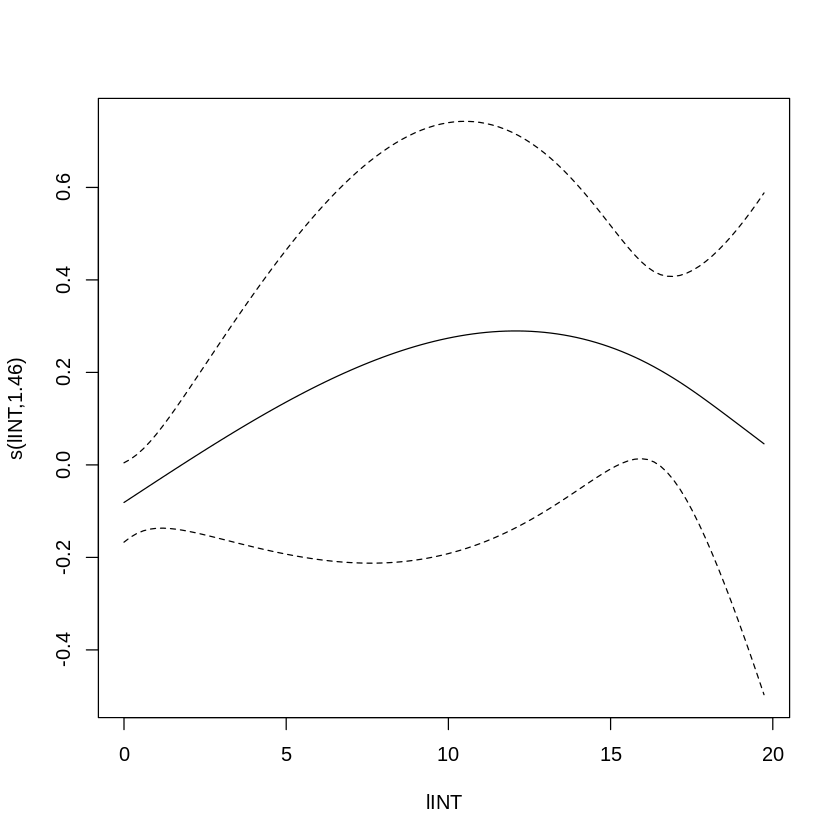

In [29]:
plot(mod.gam)

## It seems that the medium length fixes are most problematic. p-value, however, is above .05

## Time series

## Censored data

## Variable Selection using Bayesian Networks

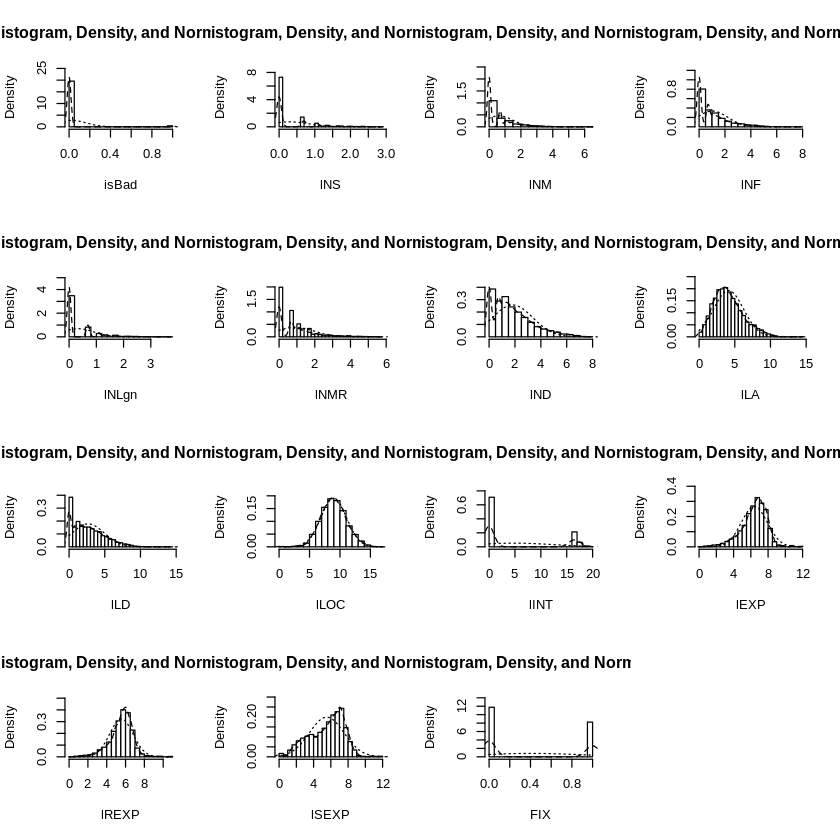

In [5]:
library(bnlearn)
library(psych)
multi.hist(data)


### Most variables closely follow a Gaussian distribution, 
### so using continuous BN structure search algorithms should be ok

Loading required namespace: Rgraphviz


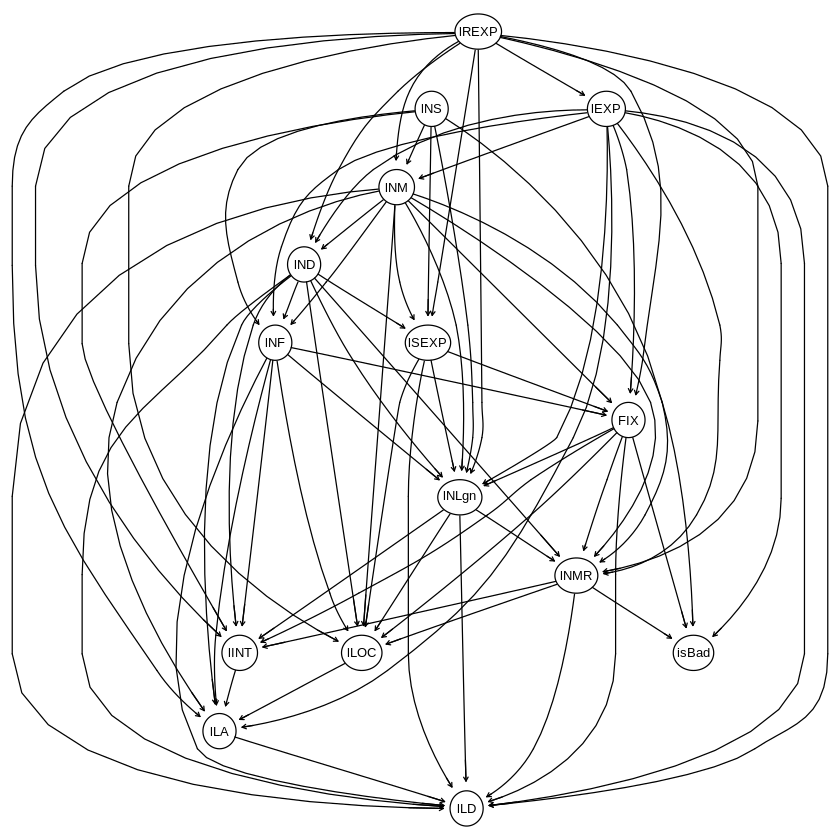

In [6]:
dag2 = hc(data, score = "bic-g", restart = 100, perturb = 2)
graphviz.plot(dag2, shape = "ellipse")

### Bootstrapping is useful in stabilizing the graph

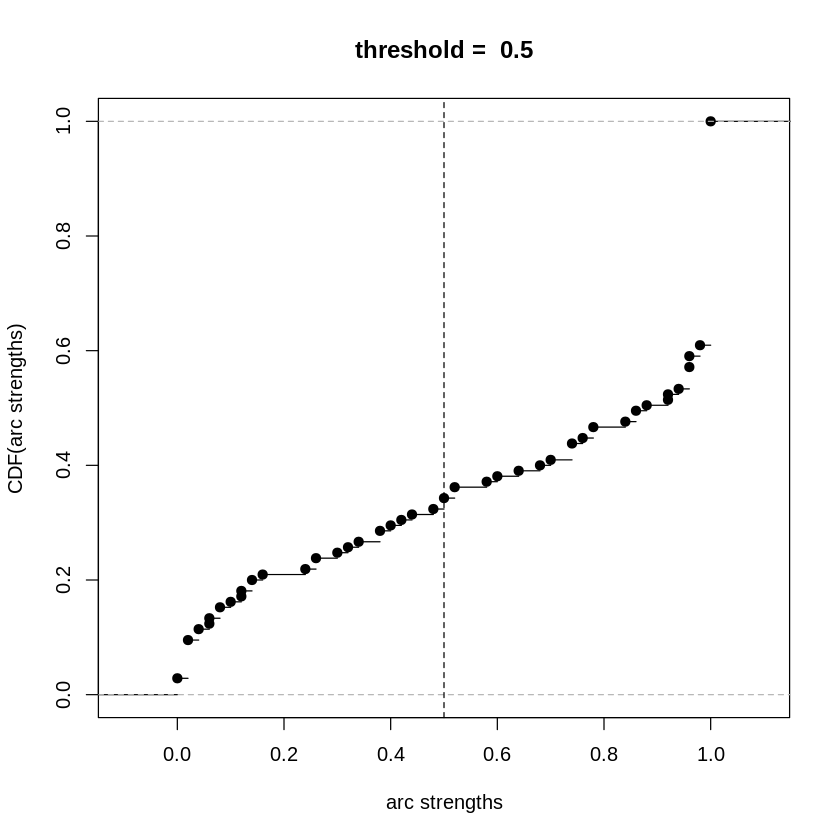

In [7]:
boot = bnlearn::boot.strength(data = data, R = 50, algorithm = "hc", 
                               algorithm.args = list(score = "bic-g",  restart = 100, perturb = 2))
plot(boot)


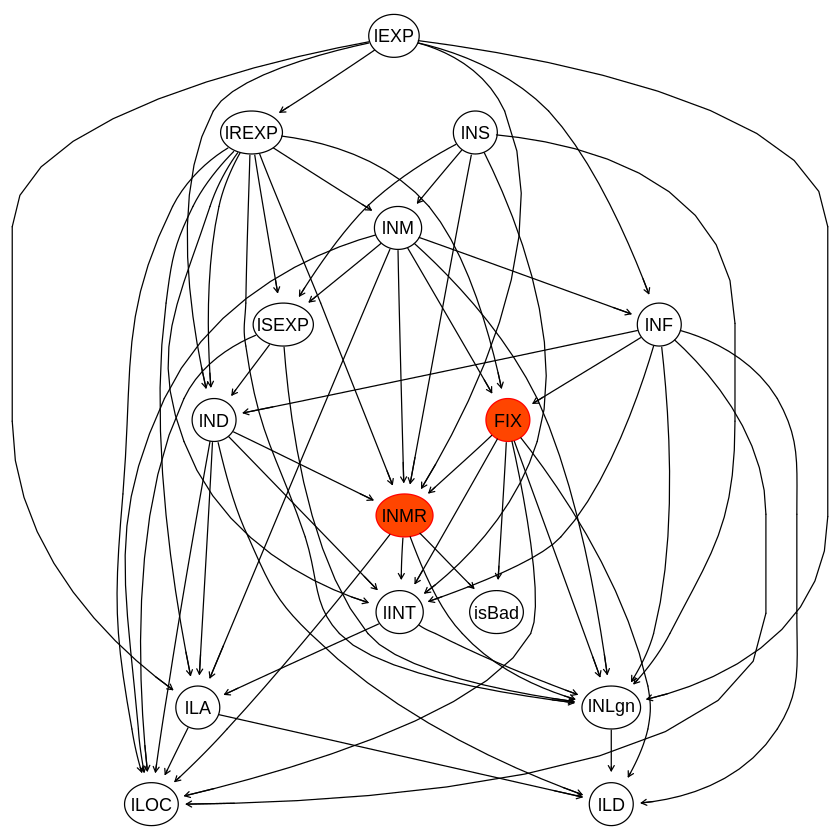

In [34]:
avg.boot = averaged.network(boot, threshold = 0.8)
graphviz.plot(avg.boot, highlight = list(nodes=bnlearn::mb(avg.boot, "isBad"), fill="orangered"),shape = "ellipse")


### Discretization further reduces clutter, makes it easier to identify the very highly correlated variables

In [27]:
data2= bnlearn::discretize(data, method="interval", breaks=2)


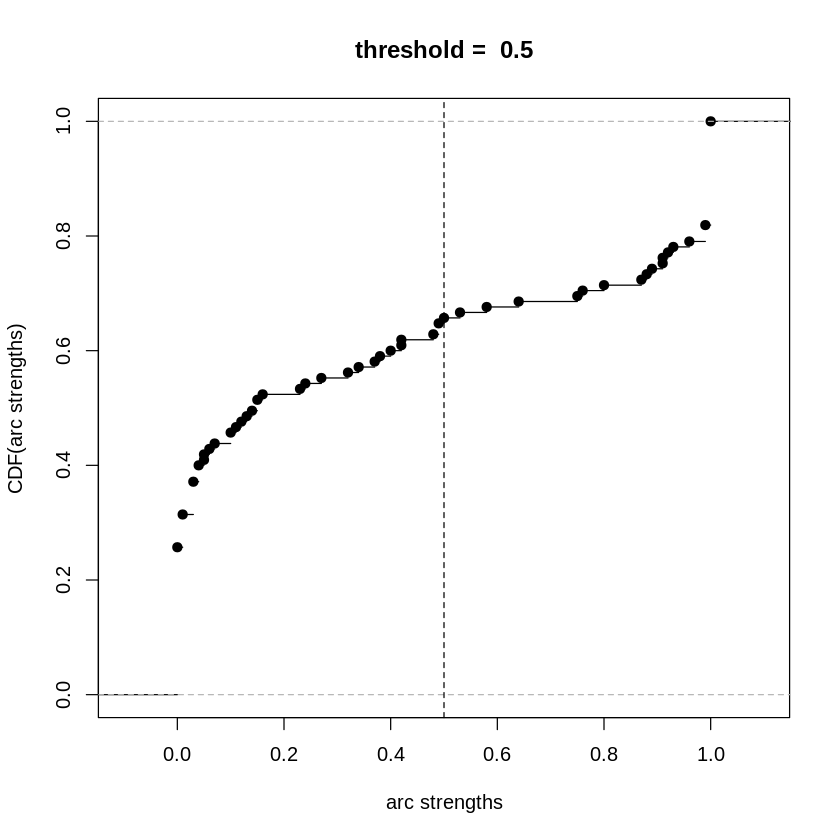

In [28]:
boot2 = bnlearn::boot.strength(data = data2, R = 100,  algorithm = "hc", algorithm.args = list(score = "bic", restart = 100, perturb = 2))
plot(boot2)

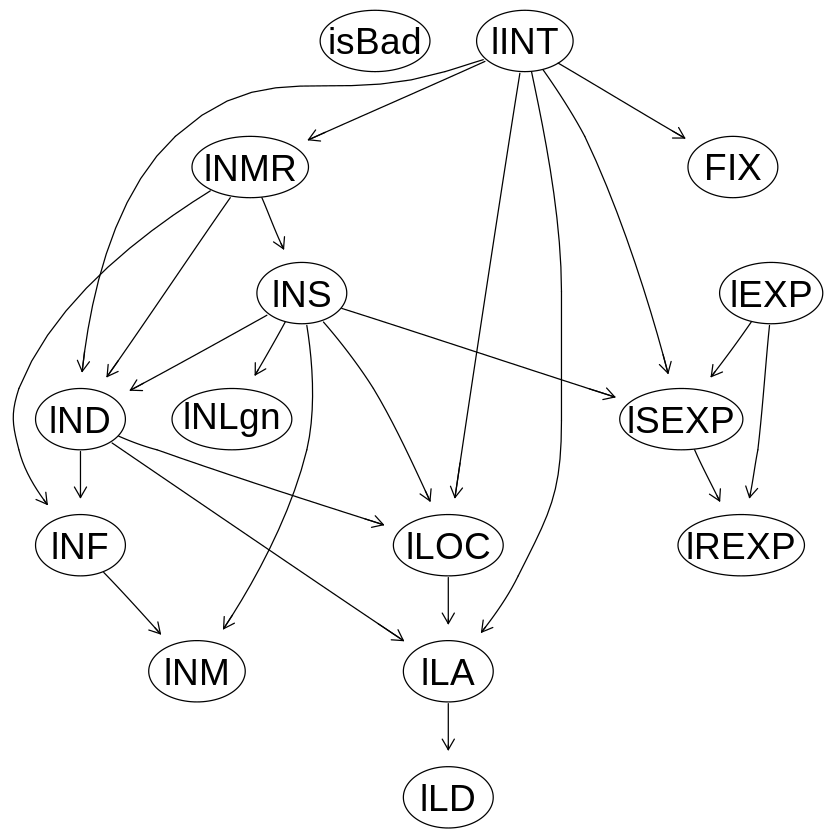

In [32]:
avg.boot2 = averaged.network(boot2, threshold = 0.95)
graphviz.plot(avg.boot2, shape = "ellipse")

### This graph is useful in showing how highly correlated variables are handled in the graphical model